# This notebook 
## 1) reads and processes .mat files from Graf 2011
## 2) computes spike counts per trial
## 3) plots tuning curves
## 4) builds a Poisson Independent Decoder (PID)
## 5) builds an L1 regularized multinomial logistic regression model
## 6) builds a Bayesian hierarchical logistic regression model 
## 7) evaluates the three models

In [1]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn import *
#from edward.models import Bernoulli, Normal

/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


In [2]:
def read_data(file_path):
    '''Read and process mat file from Graf2011
    
    param array_number: {1, 2, 3, 4, 5}

    return:
        spike_times: {Nx3600} N simultaneously recorded spike trains for 3600 trials
            (50 repeated trials of 72 direction in random order)
        orientation_per_trial: orientation for each trial (of length 3600)
        num_neurons: number of neurons
        orientations: sorted set of orientations
        num_repeats: number of repeats for each (orientation,neuron) (=50)
        num_trials: 50 repeated trials x 72 directions
        trial_length: length of trial (in seconds)
    '''
    dataStruct = scipy.io.loadmat(file_path)
    spike_times = pd.DataFrame.from_dict(dataStruct['spk_times'])
    orientation_per_trial = dataStruct['ori'][0]
    num_neurons = np.shape(dataStruct['neur_param'])[0]
    orientations = np.sort(np.unique(dataStruct['ori']))
    trial_length = 2560e-3
    num_repeats = 50
    num_trials = 3600 # 50 repeated trials x 72 directions
    num_orientations = len(orientations)
    return spike_times, orientation_per_trial, num_neurons, orientations, trial_length, num_repeats, num_trials, num_orientations

In [3]:
def compute_spike_counts(spike_times, num_neurons, num_trials):
    '''
        Compute spike counts for each (orientation, neuron, trial)
        return 3D numpy array: orientation x trials x neurons
        
        TODO: add option to average [0 180] with responses from [180 360]
    '''
    spike_times_mat = spike_times.as_matrix()
    spike_counts = np.zeros((num_orientations, num_neurons, num_repeats))
    # for each orientation
    for i in range(num_orientations):
        # access indices in spike times that corresponds to ori
        idx = np.where(orientation_per_trial == orientations[i])[0]
        spike_times_ori = np.take(spike_times_mat, idx, axis = 1)
        for j in range(num_neurons):
            for k in range(num_repeats):
                spike_counts[i, j, k] = np.count_nonzero(spike_times_ori[j][k])
    return spike_counts

In [54]:
'''
Filters to data
1) spike counts observed after 1280 ms
    - exclude
    - use to filter neurons that do not have a significantly higher mean tc with stimulus than without

2) from paper, 
To get visually driven neurons, we only accepted neurons of which the
peak or trough of their tuning curve fell outside of the window defined
by the mean and one s.d. of their spontaneous activity. Furthermore, we
obtained meaningful sample of V1 neurons by only considering neurons with
tuning curves that could be well approximated (r2   0.75) by bimodal
circular Gaussian functions (the sum of two von Mises functions with
different preferred orientations, amplitudes and bandwidths), allowing us
to accommo- date for direction (mono-modal) or orientation (bi-modal)
tuning. We obtained populations of simultaneously recorded neurons of
sizes 40, 57, 60, 70 and 74. Each data set was obtained in a ~3-h-long
recording session.

3) average across 180 degree axis?

4) if max of tc for neuron i across orientations - min of tc for neuron i across orientations is 
    not greater than 10, -> exclude neuron
    
5) divisive normalization

'''

def normalize_spike_counts(spike_counts, num_orientations, num_neurons, num_repeats):
    '''
        Normalize by variance of spike counts
        FIX: this is incorrect.
    '''
    spike_counts_norm = np.zeros((num_orientations, num_neurons, num_repeats))
    for i in range(num_repeats):
        variance_sum = np.sum(spike_counts[:, :, i]**2, axis = 1)
        spike_counts_norm[:, :, i] = (spike_counts[:, :, i]**2) / variance_sum.reshape(-1,1)
    return spike_counts_norm

In [5]:
def compute_mean_tc(spike_counts):
    return np.mean(spike_counts, axis=2)

def compute_var_tc(spike_counts):
    return np.var(spike_counts, axis=2)

def compute_cov_tc(spike_counts):
    tc_cov = np.zeros((num_neurons, num_neurons, num_orientations))
    for i in range(num_orientations):
        tc_cov[:, :, i] = np.cov(spike_counts[i])
    return tc_cov

In [53]:
def compute_preferred_orientation(mean_tc, num_neurons):
    '''max of tuning curve across orientations'''
    pref_ori = np.zeros(147)
    for i in range(num_neurons):
        pref_ori[i] = np.argmax(mean_tc[:,i])
    return pref_ori

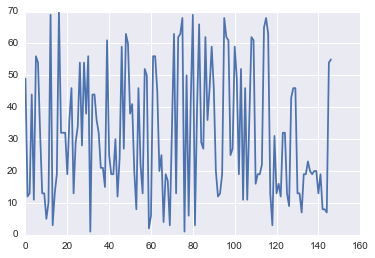

In [52]:
plt.plot(pref_ori)

In [7]:
def filter_to_well_tuned_neurons(mean_tc, thresh):
    '''Filter to well tuned neurons, example thresh = 10'''
    maxdiff = np.max(mean_tc, axis=0) - np.min(mean_tc, axis=0)
    ind_tuned = np.where(maxdiff > thresh)[0]
    return ind_tuned

In [15]:
# path to mat file from Graf 2011
file_path = '../../data/graf_V1data/array_1.mat'

# read and process data
spike_times, orientation_per_trial, num_neurons, orientations, trial_length,\
    num_repeats, num_trials, num_orientations = read_data(file_path)

# compute spike counts
spike_counts = compute_spike_counts(spike_times, num_neurons, num_trials)

# compute tuning curves
mean_tc = compute_mean_tc(spike_counts)
var_tc = compute_var_tc(spike_counts)
cov_tc = compute_cov_tc(spike_counts)

# identify indices for well-tuned neurons
ind_well_tuned = filter_to_well_tuned_neurons(mean_tc, 10)

# normalize spike counts
spike_counts_norm = normalize_spike_counts(spike_counts, num_orientations, num_neurons, num_repeats)

# compute normalized tuning curves
mean_tc_norm = compute_mean_tc(spike_counts_norm)
var_tc_norm = compute_var_tc(spike_counts_norm)
cov_tc_norm = compute_cov_tc(spike_counts_norm)

In [18]:
mean_tc.shape

(72, 147)

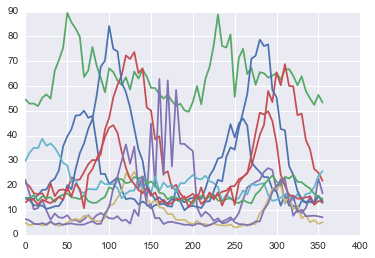

In [10]:
# plot mean tuning curve for 10 well tuned neurons
%matplotlib inline
sns.set_style("darkgrid")
plt.plot(orientations, mean_tc[:, ind_well_tuned[0:10]]);

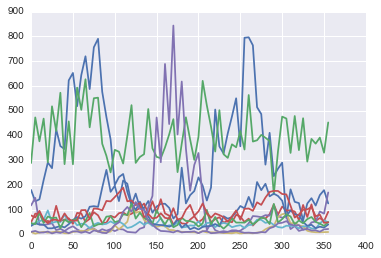

In [11]:
# plot variance tuning curve for 10 well tuned neurons
plt.plot(orientations, var_tc[:, ind_well_tuned[0:10]]);

### Lets build a Poisson Independent Decoder (PID). We assume each neuron's stimulus-specific spike counts is Poisson distributed and statistically independent across neurons. The rate parameter $w_i(\theta)$ is the logarithm of the mean neuronal tuning function for neuron i across trials for stimulus $\theta$.

### The likelihood function is $\log L(\theta) = \sum_{i=1}^N w_i(\theta)r_i + b(\theta)$. The offset b incorporates overall bias in coverage of orientations and is the sum of the mean tuning curve across neurons for stimulus $\theta$.

In [349]:
def create_train_test_split_OLD(spike_counts, thresh):
    # create train/test split
    train_test_split = (thresh, 1-thresh)
    x = np.transpose(spike_counts, (0, 2, 1)) # orientation x samples x neurons
    
    X_train, X_test = np.zeros((int(x.shape[0] * x.shape[1] * train_test_split[0]), x.shape[2])), \
        np.zeros((int(x.shape[0] * x.shape[1] * train_test_split[1]), x.shape[2]))
    Y_train, Y_test = np.zeros(int(x.shape[0] * x.shape[1] * train_test_split[0])), \
        np.zeros(int(x.shape[0] * x.shape[1] * train_test_split[1]))

    # for each orientation
    for i in range(72):
        num_samples = x[i].shape[0]
        num_neurons = x[i].shape[1]
        train_ind_break = int(train_test_split[0] * num_samples)
        test_ind_break = int(train_test_split[1] * num_samples)
        # shuffle sample indices
        indices = np.random.permutation(x[i].shape[0])

        x_train = x[i][indices[0 : train_ind_break]]
        x_test = x[i][indices[0 : test_ind_break]]
        X_train[i * train_ind_break : (i+1) * train_ind_break] = x_train
        X_test[i * test_ind_break : (i+1) * test_ind_break] = x_test
        Y_train[i * train_ind_break : (i+1) * train_ind_break] = i+1
        Y_test[i * test_ind_break : (i+1) * test_ind_break] = i+1
    return X_train, X_test, Y_train, Y_test

In [421]:
def train_test_split(spike_counts, t):
    '''train test split'''

    x = np.transpose(spike_counts, (0, 2, 1)) # rearrange dimensions to ori x samples x neurons
    x_train, x_test, y_train, y_test = [], [], [], []
    thresh = t # train / test split 
    train_ind = int(num_repeats * thresh)
    for i in range(72):
        x_train.append(x[i][0:train_ind])
        x_test.append(x[i][train_ind:])
        y_train.append(np.repeat((i+1), train_ind))
        y_test.append(np.repeat((i+1), num_repeats - train_ind))
    return np.array(x_train), np.array(x_test), \
        np.ravel(np.array(y_train)), np.ravel(np.array(y_test))

In [500]:
def compute_mean_tc(x):
    '''compute mean tuning curve given training data (orientation,samples) x neurons'''
    mean_tc = np.zeros((x.shape[0], x.shape[2]))
    for i in range(72):
        mean_tc[i] = np.mean(x[i], axis = 0)
    return mean_tc

In [517]:
spike_counts.shape

(72, 113, 50)

In [518]:
spike_counts_filtered = spike_counts[:, ind_well_tuned, :]

In [519]:
spike_counts_filtered.shape

(72, 49, 50)

In [520]:
# filter to well-tuned neurons
spike_counts_filt = spike_counts[:, ind_well_tuned, :]

# generate train/test split
x_train, x_test, y_train, y_test = train_test_split(spike_counts_filt, .7)

# compute filtered w, filtered x, and b
mean_tc = compute_mean_tc(x_train)
filter_inds = filter_to_well_tuned_neurons(mean_tc, 10)
w = np.log(mean_tc[:, filter_inds])
x_train = x_train[:,:,filter_inds]
x_test = x_test[:,:,filter_inds]
b = np.sum(w, axis=1)

In [521]:
w.shape, b.shape, x_train.shape

((72, 32), (72,), (72, 35, 32))

In [530]:
def likelihood(w_i, r_i, b_i):
    '''Compute data likelihood given w, r, b for stimulus i'''
    return np.log(np.sum(np.dot(w_i, r_i.T)) + b_i)

In [533]:
def plot_likelihood(w, x_train, b, stimulus_choice):
    '''plot likelihood of stimulus-specific spike train as a function of model choice'''
    sx = []
    for i in range(72):
        sx.append(likelihood(w[i], x_train[stimulus_choice], b[i]))
    fig = plt.plot(sx)

In [553]:
np.max(sx)

60944.607053935732

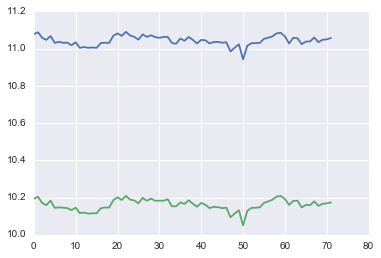

In [551]:
# likelihood comparison -- which model provides best explanation of the data?,
plot_likelihood(w, x_train, b, 1) # for example, we fit spike trains from ori 1 against all possible models
plot_likelihood(w, x_test, b, 1)

In [ ]:
# write a few evaluation metrics
# compute max of log likelihood use that orientation as "prediction"

### Lets build a L1 regularized multinomial multi-class logistic regression model

In [772]:
# specify model
lr = sklearn.linear_model.LogisticRegression(penalty='l1', fit_intercept=True)

# fit the model
lr.fit(x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2]), y_train)

# predict labels and probability distributions on test data
labels_test = lr.predict(x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2]))
scores_test = lr.predict_proba(x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2]))

In [773]:
def evaluate_one_versus_all(y_test, scores):
    '''AUC scores for one versus all classification on test data across all classes'''
    aucs = []
    for j in range(72):
        sx = []
        for i in range(len(y_test)):
            if y_test[i] == (j+1):
                sx.append(int(1))
            else:
                sx.append(int(0))
        aucs.append(sklearn.metrics.roc_auc_score(np.array(sx),scores[:,j]))
    plt.figure(figsize=(10,5))
    plt.scatter(np.arange(72),aucs)
    plt.xlabel('class')
    plt.ylabel('auc')

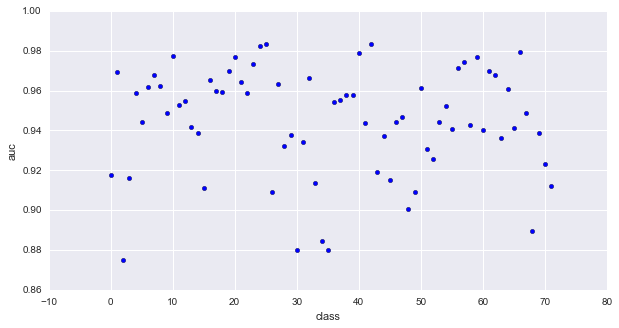

In [774]:
evaluate_one_versus_all(y_test, scores_test)

In [758]:
def evaluate_one_versus_one(y_test, scores, delta):
    '''AUC scores for one class versus one class on test data across all classes
        delta, int : discriminate between class and class + delta    
    '''
    aucs = []
    for j in range(1,73):
        inds = np.concatenate((np.where(y_test == (j))[0], np.where(y_test == (((j-1)+delta) % 72) + 1)[0]))
        #print(y_test[inds])
        #print(scores[inds,j-1])
        y = (y_test[inds] == j).astype(int)
        aucs.append((sklearn.metrics.roc_auc_score(y, scores[inds,j-1])))
    plt.figure(figsize=(10,5))
    plt.scatter(np.arange(72),aucs)
    plt.xlabel('class')
    plt.ylabel('auc')

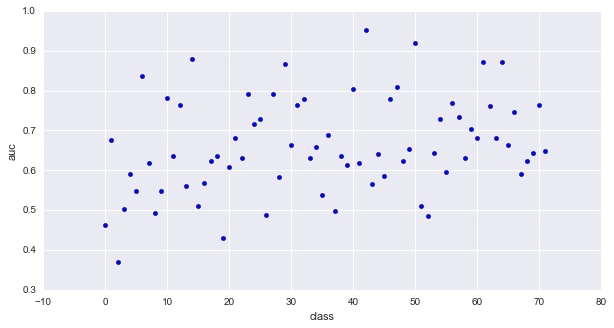

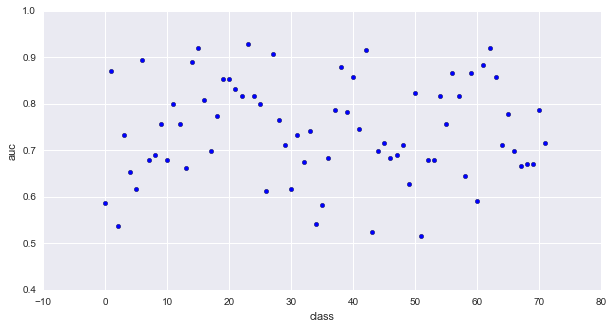

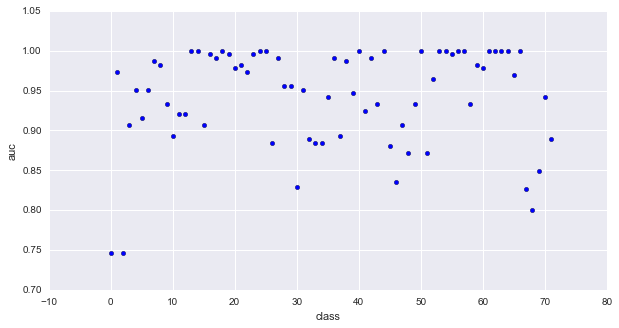

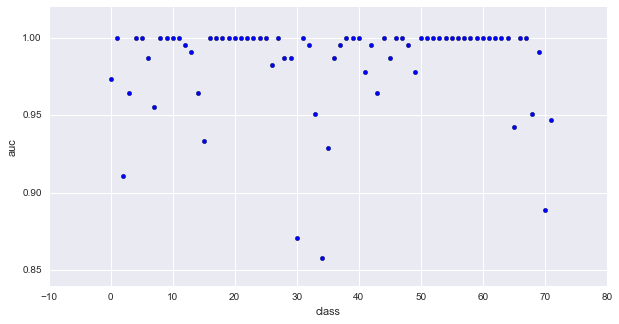

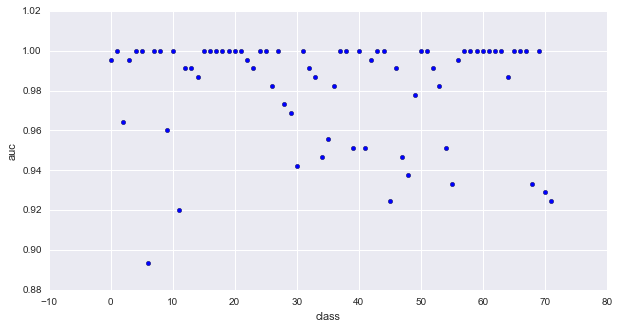

In [776]:
evaluate_one_versus_one(y_test, proba_test, 1)
evaluate_one_versus_one(y_test, proba_test, 2)
evaluate_one_versus_one(y_test, proba_test, 5)
evaluate_one_versus_one(y_test, proba_test, 10)
evaluate_one_versus_one(y_test, proba_test, 20)

## Takeaway: model does poorly at discriminating between orientations 5 degrees a part (consistent with paper) and does better aas delta increases

### Lets build a Bayesian multinomial multi-class logistic regression model
$$p(\theta^{(i)} = c | r^{(i)}, w^{(c)}) = \frac{\exp{(w^{(c)T}r^{(i)})}}{\sum_{j=1}^C(w^{(j)T}r^{(i)})}$$
$$p(w^{(c)}|\Lambda^{(c)}) = \mathcal{N}(0, \Lambda^{(c)}), \Lambda^{(c)} \in \mathcal{R^{\text{NxN}}}$$

In [257]:
for train_index, test_index in sss:
    print(train_index.shape, test_index.shape)

(2304,) (1296,)


In [227]:
len(np.unique(y[test_index]))

72

In [161]:
spike_counts1.reshape(147, 3600)

array([[  1.,   1.,   1., ...,   6.,   0.,   2.],
       [  1.,   1.,   3., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ..., 
       [  0.,   0.,   0., ...,  11.,   1.,   7.],
       [  0.,   0.,   6., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   9.,   0.,   0.]])

In [153]:
w = mean_tc
b = np.sum(mean_tc, axis=1)

In [137]:
mean_tc.shape

(72, 147)

In [150]:
b

array([ 426.76,  413.28,  430.78,  469.68,  453.72,  452.44,  476.02,
        459.1 ,  494.96,  497.2 ,  488.3 ,  545.36,  475.44,  596.08,
        470.5 ,  514.8 ,  505.72,  495.64,  506.64,  594.22,  564.5 ,
        524.8 ,  524.6 ,  504.8 ,  512.54,  502.86,  467.3 ,  476.12,
        481.6 ,  488.22,  486.42,  458.9 ,  485.9 ,  460.44,  453.08,
        458.34,  432.46,  453.82,  423.96,  440.46,  457.82,  436.96,
        492.56,  482.24,  504.74,  450.42,  535.86,  509.54,  515.06,
        536.52,  554.42,  483.38,  480.46,  500.42,  542.84,  506.58,
        566.12,  506.18,  474.02,  506.8 ,  497.98,  526.18,  557.38,
        489.58,  486.86,  423.48,  434.28,  444.  ,  472.1 ,  465.84,
        437.98,  474.14])

In [37]:
# orientatino-dependent offset term B represents sum across unnormalized individual tuning curves
B = np.sum(compute_mean_tc(spike_counts), axis=1)

In [42]:
B.shape

(72,)

In [ ]:
mean_tc

In [44]:
spike_counts_norm[0].shape

(147, 50)

In [47]:
spike_counts_norm.shape

(72, 147, 50)

In [113]:
sp_train = spike_counts[0::36]

In [58]:
sp_train.shape

(2, 147, 50)

In [115]:
sp_train1 = np.concatenate((sp_train[0].T, sp_train[1].T))

In [117]:
xtrain, xtest, ytrain, ytest = sp_train1[0::2], sp_train1[1::2], y[0::2], y[1::2]

In [102]:
ytrain

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [66]:
y = np.ones(100)
y[0:50] = 0

In [116]:
sp_train1.shape

(100, 147)

In [98]:
import sklearn
from sklearn import linear_model

In [258]:
lg = multiclass.OneVsRestClassifier(linear_model.LogisticRegression(penalty='l2', fit_intercept=True)).fit(x[train_index],y[train_index])

In [259]:
lg.coef_.shape

(72, 147)

In [112]:
xtrain,ytrain

(array([[ 0.00215054,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00196078,  0.        ,  0.        , ...,  0.        ,
          0.00784314,  0.        ],
        [ 0.00755972,  0.00030239,  0.        , ...,  0.        ,
          0.00120956,  0.00030239],
        ..., 
        [ 0.00660066,  0.00010314,  0.00835396, ...,  0.        ,
          0.01485149,  0.00010314],
        [ 0.0023571 ,  0.0023571 ,  0.0094284 , ...,  0.        ,
          0.0023571 ,  0.0023571 ],
        [ 0.        ,  0.00125431,  0.01128881, ...,  0.        ,
          0.00501725,  0.00125431]]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]))

In [90]:
xtrain, ytrain

(array([[ 0.00215054,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00196078,  0.        ,  0.        , ...,  0.        ,
          0.00784314,  0.        ],
        [ 0.00755972,  0.00030239,  0.        , ...,  0.        ,
          0.00120956,  0.00030239],
        ..., 
        [ 0.00660066,  0.00010314,  0.00835396, ...,  0.        ,
          0.01485149,  0.00010314],
        [ 0.0023571 ,  0.0023571 ,  0.0094284 , ...,  0.        ,
          0.0023571 ,  0.0023571 ],
        [ 0.        ,  0.00125431,  0.01128881, ...,  0.        ,
          0.00501725,  0.00125431]]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]))

In [121]:
lg.score(xtest, ytest)

0.57999999999999996

In [248]:
lg.predict_proba(x[test_index]).shape

(720, 72)

In [250]:
y[test_index].shape

(720,)

In [261]:
lg.predict(x[test_index]).shape

(1296,)

In [263]:
sklearn.metrics.accuracy_score(y[test_index], lg.predict(x[test_index]))

0.12422839506172839

In [249]:
sklearn.metrics.roc_auc_score(y[test_index], lg.predict_proba(x[test_index])[:,0])

ValueError: multiclass format is not supported

In [266]:
np.where(y[test_index] == 2 || y[test_index] == 3).any()

SyntaxError: invalid syntax (<ipython-input-266-372c62225565>, line 1)

In [237]:
np.where(y[test_index] == 1)[0].shape

(10,)

In [238]:
for i in range(1,72):
    ind = np.where(y[test_index]==1)[0]
    y1 = y[ind]
    x1 = x[ind]
    sklearn.metrics.roc_auc_score(y1, lg.predict_proba(x1)[:,1])

ValueError: multiclass format is not supported

In [241]:
lg.decision_function(x[test_index])

array([[-28.88725363, -19.55507943, -21.01102012, ..., -35.35186633,
        -24.13614079,  -8.63188668],
       [-27.61865971, -20.38865255, -67.50206954, ..., -28.14236094,
        -16.83661718, -21.79705698],
       [-16.13644042, -14.83539246, -36.79774769, ..., -18.54589066,
        -19.43193987, -12.95596999],
       ..., 
       [-10.43370831, -12.66193196, -17.13031075, ..., -26.3655129 ,
        -12.51541379,  -5.38092497],
       [ -8.14102475, -17.59344286, -13.18642775, ...,  -3.15718664,
         -5.99543257, -11.16650745],
       [-22.9926645 , -25.84811421, -22.56100689, ..., -17.75736728,
         -3.71337097, -10.82433941]])